IMPORTING LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mp

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization

READING TRAINING & TESTING DATA

In [2]:
df_train = pd.read_csv('Taxi_Fare_Prediction_Training_Data.csv')
df_test  = pd.read_csv('Taxi_Fare_Prediction_Testing_Data.csv')

df_train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayOfWeek,hour,timeOfDayMid.Day,timeOfDayMorning,timeOfDayNight
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,1,6,15,2,17,0,0,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2,1,5,3,16,0,0,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,3,8,18,5,0,0,0,1
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,4,21,7,4,0,1,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2,3,9,3,7,0,1,0


In [3]:
df_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayOfWeek,hour,timeOfDayMid.Day,timeOfDayMorning,timeOfDayNight
0,-73.973320,40.763805,-73.981430,40.743835,1,7,1,27,3,13,1,0,0
1,-73.986862,40.719383,-73.998886,40.739201,1,7,1,27,3,13,1,0,0
2,-73.982524,40.751260,-73.979654,40.746139,1,3,10,8,7,11,1,0,0
3,-73.981160,40.767807,-73.990448,40.751635,1,4,12,1,7,21,0,0,1
4,-73.966046,40.789775,-73.988565,40.744427,1,4,12,1,7,21,0,0,1


CLEANING THE DATA

In [4]:
# Delimiter latitiudes and longitudes to New York only
df_train = df_train[( 38 <= df_train['pickup_latitude'])   & (df_train['pickup_latitude']   <=  42)]
df_train = df_train[(-76 <= df_train['pickup_longitude'])  & (df_train['pickup_longitude']  <= -72)]
df_train = df_train[( 38 <= df_train['dropoff_latitude'])  & (df_train['dropoff_latitude']  <=  42)]
df_train = df_train[(-76 <= df_train['dropoff_longitude']) & (df_train['dropoff_longitude'] <= -72)]
    
# Remove possible outliers
df_train = df_train[(0 < df_train['fare_amount']) & (df_train['fare_amount'] <= 250)]
    
# Remove inconsistent values
df_train = df_train[(df_train['pickup_latitude']  != df_train['dropoff_latitude'])]
df_train = df_train[(df_train['pickup_longitude'] != df_train['dropoff_longitude'])]

df_train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayOfWeek,hour,timeOfDayMid.Day,timeOfDayMorning,timeOfDayNight
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,1,6,15,2,17,0,0,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2,1,5,3,16,0,0,0
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,3,8,18,5,0,0,0,1
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,4,21,7,4,0,1,0
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2,3,9,3,7,0,1,0


ADDING NEW COLUMNS TO THE DATA

In [5]:
def add_new_features(df):

  # Adding new features
  df['latitude_difference']  = df['pickup_latitude']  - df['dropoff_latitude']
  df['longitude_difference'] = df['pickup_longitude'] - df['dropoff_longitude']
    
  # Adding Manhattan Distances from Airport to Downtown
  ap1 = (-74.0063889, 40.7141667)
  ap2 = (-73.7822222222, 40.6441666667)
  ap3 = (-74.175, 40.69)
  ap4 = (-73.87, 40.77)

  df['euclidean_distance'] = (df['latitude_difference'] ** 2 + df['longitude_difference'] ** 2) ** 0.5
  df['manhattan_distance'] = np.abs(df['dropoff_latitude'] - df['pickup_latitude']) + np.abs(df['dropoff_longitude'] - df['pickup_longitude'])
    
  df['ap1_pickup_distance']  = np.abs(df['pickup_latitude']  - ap1[1]) + np.abs(df['pickup_longitude']  - ap1[0])
  df['ap1_dropoff_distance'] = np.abs(df['dropoff_latitude'] - ap1[1]) + np.abs(df['dropoff_longitude'] - ap1[0])
  df['ap2_pickup_distance']  = np.abs(df['pickup_latitude']  - ap2[1]) + np.abs(df['pickup_longitude']  - ap2[0])
  df['ap2_dropoff_distance'] = np.abs(df['dropoff_latitude'] - ap2[1]) + np.abs(df['dropoff_longitude'] - ap2[0])
  df['ap3_pickup_distance']  = np.abs(df['pickup_latitude']  - ap3[1]) + np.abs(df['pickup_longitude']  - ap3[0])
  df['ap3_dropoff_distance'] = np.abs(df['dropoff_latitude'] - ap3[1]) + np.abs(df['dropoff_longitude'] - ap3[0])
  df['ap4_pickup_distance']  = np.abs(df['pickup_latitude']  - ap4[1]) + np.abs(df['pickup_longitude']  - ap4[0])
  df['ap4_dropoff_distance'] = np.abs(df['dropoff_latitude'] - ap4[1]) + np.abs(df['dropoff_longitude'] - ap4[0])

  return df

df_train = add_new_features(df_train)
df_test  = add_new_features(df_test)

In [6]:
df_train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayOfWeek,...,euclidean_distance,manhattan_distance,ap1_pickup_distance,ap1_dropoff_distance,ap2_pickup_distance,ap2_dropoff_distance,ap3_pickup_distance,ap3_dropoff_distance,ap4_pickup_distance,ap4_dropoff_distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,1,6,15,2,...,0.009436,0.011742,0.169230,0.166668,0.139241,0.127499,0.362008,0.355668,0.074370,0.086112
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2,1,5,3,...,0.079696,0.107481,0.012523,0.094958,0.300962,0.334883,0.180255,0.287736,0.204745,0.121272
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,3,8,18,5,...,0.013674,0.019212,0.070754,0.051542,0.317619,0.315415,0.263532,0.244320,0.121468,0.140680
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,4,4,21,7,...,0.025340,0.029386,0.038235,0.058747,0.293884,0.323270,0.231013,0.251525,0.153987,0.133475
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2,3,9,3,...,0.019470,0.027194,0.092135,0.119329,0.309714,0.314028,0.284913,0.312107,0.100087,0.100417


In [7]:
df_test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayOfWeek,hour,...,euclidean_distance,manhattan_distance,ap1_pickup_distance,ap1_dropoff_distance,ap2_pickup_distance,ap2_dropoff_distance,ap3_pickup_distance,ap3_dropoff_distance,ap4_pickup_distance,ap4_dropoff_distance
0,-73.973320,40.763805,-73.981430,40.743835,1,7,1,27,3,13,...,0.021554,0.028080,0.082708,0.054628,0.310737,0.298877,0.275485,0.247405,0.109515,0.137595
1,-73.986862,40.719383,-73.998886,40.739201,1,7,1,27,3,13,...,0.023180,0.031841,0.024743,0.032537,0.279857,0.311698,0.217521,0.225314,0.167479,0.159686
2,-73.982524,40.751260,-73.979654,40.746139,1,3,10,8,7,11,...,0.005870,0.007991,0.060958,0.058707,0.307395,0.299404,0.253736,0.251485,0.131264,0.133515
3,-73.981160,40.767807,-73.990448,40.751635,1,4,12,1,7,21,...,0.018649,0.025460,0.078869,0.053409,0.322578,0.315694,0.271647,0.246187,0.113353,0.138813
4,-73.966046,40.789775,-73.988565,40.744427,1,4,12,1,7,21,...,0.050631,0.067867,0.115951,0.048084,0.329432,0.306603,0.308729,0.240862,0.115821,0.144138


DROPPING UNWANTED COLUMNS FROM THE DATA

In [8]:
cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','passenger_count']

df_train = df_train.drop(cols, axis=1)
df_test  = df_test.drop(cols, axis=1)

df_train.head()

,fare_amount,year,month,day,dayOfWeek,hour,timeOfDayMid.Day,timeOfDayMorning,timeOfDayNight,latitude_difference,...,euclidean_distance,manhattan_distance,ap1_pickup_distance,ap1_dropoff_distance,ap2_pickup_distance,ap2_dropoff_distance,ap3_pickup_distance,ap3_dropoff_distance,ap4_pickup_distance,ap4_dropoff_distance
0,4.5,1,6,15,2,17,0,0,0,0.009041,...,0.009436,0.011742,0.169230,0.166668,0.139241,0.127499,0.362008,0.355668,0.074370,0.086112
1,16.9,2,1,5,3,16,0,0,0,-0.070701,...,0.079696,0.107481,0.012523,0.094958,0.300962,0.334883,0.180255,0.287736,0.204745,0.121272
2,5.7,3,8,18,5,0,0,0,1,0.010708,...,0.013674,0.019212,0.070754,0.051542,0.317619,0.315415,0.263532,0.244320,0.121468,0.140680
3,7.7,4,4,21,7,4,0,1,0,-0.024949,...,0.025340,0.029386,0.038235,0.058747,0.293884,0.323270,0.231013,0.251525,0.153987,0.133475
4,5.3,2,3,9,3,7,0,1,0,-0.015754,...,0.019470,0.027194,0.092135,0.119329,0.309714,0.314028,0.284913,0.312107,0.100087,0.100417


In [9]:
df_test.head()

,year,month,day,dayOfWeek,hour,timeOfDayMid.Day,timeOfDayMorning,timeOfDayNight,latitude_difference,longitude_difference,euclidean_distance,manhattan_distance,ap1_pickup_distance,ap1_dropoff_distance,ap2_pickup_distance,ap2_dropoff_distance,ap3_pickup_distance,ap3_dropoff_distance,ap4_pickup_distance,ap4_dropoff_distance
0,7,1,27,3,13,1,0,0,0.019970,0.008110,0.021554,0.028080,0.082708,0.054628,0.310737,0.298877,0.275485,0.247405,0.109515,0.137595
1,7,1,27,3,13,1,0,0,-0.019817,0.012024,0.023180,0.031841,0.024743,0.032537,0.279857,0.311698,0.217521,0.225314,0.167479,0.159686
2,3,10,8,7,11,1,0,0,0.005121,-0.002870,0.005870,0.007991,0.060958,0.058707,0.307395,0.299404,0.253736,0.251485,0.131264,0.133515
3,4,12,1,7,21,0,0,1,0.016172,0.009288,0.018649,0.025460,0.078869,0.053409,0.322578,0.315694,0.271647,0.246187,0.113353,0.138813
4,4,12,1,7,21,0,0,1,0.045348,0.022519,0.050631,0.067867,0.115951,0.048084,0.329432,0.306603,0.308729,0.240862,0.115821,0.144138


SPLITTING TRAINING DATA INTO TRAINING & VALIDATE DATA

In [10]:
df_train, df_validate = train_test_split(df_train, test_size=0.10, random_state=1)

df_train_fare_amount    = df_train['fare_amount'].values
df_validate_fare_amount = df_validate['fare_amount'].values

df_train    = df_train.drop('fare_amount', axis=1)
df_validate = df_validate.drop('fare_amount', axis=1)

df_train.head()

,year,month,day,dayOfWeek,hour,timeOfDayMid.Day,timeOfDayMorning,timeOfDayNight,latitude_difference,longitude_difference,euclidean_distance,manhattan_distance,ap1_pickup_distance,ap1_dropoff_distance,ap2_pickup_distance,ap2_dropoff_distance,ap3_pickup_distance,ap3_dropoff_distance,ap4_pickup_distance,ap4_dropoff_distance
616852,5,7,12,6,15,0,0,0,0.007670,0.005617,0.009507,0.013287,0.068964,0.055677,0.308613,0.306560,0.261742,0.248455,0.123258,0.136545
716338,2,12,16,5,0,0,0,1,-0.009595,-0.042733,0.043797,0.052328,0.074330,0.126658,0.290679,0.257541,0.267108,0.319436,0.117892,0.065564
130071,5,12,26,5,21,0,0,1,-0.001807,0.042250,0.042289,0.044057,0.188727,0.148284,0.220136,0.264193,0.381505,0.341062,0.006525,0.050582
298134,4,8,12,1,21,0,0,1,-0.000169,-0.011141,0.011142,0.011310,0.033557,0.044867,0.306118,0.295146,0.226335,0.237645,0.158665,0.147355
164107,5,12,7,7,8,0,1,0,0.005637,0.015252,0.016260,0.020889,0.070479,0.049590,0.322402,0.332017,0.263257,0.242368,0.121743,0.142632


In [11]:
df_validate.head()

,year,month,day,dayOfWeek,hour,timeOfDayMid.Day,timeOfDayMorning,timeOfDayNight,latitude_difference,longitude_difference,euclidean_distance,manhattan_distance,ap1_pickup_distance,ap1_dropoff_distance,ap2_pickup_distance,ap2_dropoff_distance,ap3_pickup_distance,ap3_dropoff_distance,ap4_pickup_distance,ap4_dropoff_distance
578199,6,2,8,7,22,0,0,1,0.032823,0.021726,0.039362,0.054549,0.114577,0.060028,0.308716,0.297619,0.307355,0.252806,0.095105,0.132194
265377,2,8,28,7,14,0,0,0,0.022136,0.108206,0.110447,0.130342,0.193356,0.063014,0.220709,0.306779,0.386134,0.255792,0.007098,0.129208
201101,5,12,18,4,21,0,0,1,-0.018507,-0.007860,0.020107,0.026367,0.092379,0.118746,0.295260,0.305907,0.285157,0.311524,0.099843,0.092296
229276,4,6,16,7,16,0,0,0,-0.003482,-0.008921,0.009576,0.012403,0.074386,0.086789,0.305257,0.299818,0.267164,0.279567,0.117836,0.105433
992151,3,10,5,4,12,1,0,0,-0.008503,-0.005860,0.010327,0.014363,0.079974,0.094337,0.307019,0.309662,0.272752,0.287115,0.112248,0.097885


SCALING THE TRAINING, VALIDATE & TESING DATA USING MIN_MAX_SCALER 

In [12]:
sc = preprocessing.MinMaxScaler()

df_train    = sc.fit_transform(df_train)
df_validate = sc.transform(df_validate)
df_test     = sc.transform(df_test)

CREATING A SEQUENTIAL MODEL

In [12]:
model = Sequential()

model.add(Dense(256, activation = 'relu', input_dim = df_train.shape[1]))
model.add(BatchNormalization())

model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())

model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())

model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())

model.add(Dense(8, activation = 'relu'))
model.add(BatchNormalization())

model.add(Dense(1))

model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

TRAINING THE MODEL ON TRAINING & VALIDATE DATA

In [13]:
history = model.fit(x = df_train, y = df_train_fare_amount, batch_size = 256, epochs = 50, verbose = 1, validation_data = (df_validate, df_validate_fare_amount), shuffle = True)

Epoch 1/50
3646/3646 [==============================] - 46s 11ms/step - loss: 22.3868 - mae: 3.0287 - val_loss: 7.1849 - val_mae: 1.7075
Epoch 2/50
3646/3646 [==============================] - 47s 13ms/step - loss: 7.2145 - mae: 1.6742 - val_loss: 7.5244 - val_mae: 1.8059
Epoch 3/50
3646/3646 [==============================] - 46s 13ms/step - loss: 6.9881 - mae: 1.6348 - val_loss: 8.6995 - val_mae: 1.8954
Epoch 4/50
3646/3646 [==============================] - 43s 12ms/step - loss: 6.8714 - mae: 1.6164 - val_loss: 8.2745 - val_mae: 2.0429
Epoch 5/50
3646/3646 [==============================] - 46s 12ms/step - loss: 6.7617 - mae: 1.5982 - val_loss: 6.7205 - val_mae: 1.5591
Epoch 6/50
3646/3646 [==============================] - 42s 11ms/step - loss: 6.5554 - mae: 1.5642 - val_loss: 6.4635 - val_mae: 1.5181
Epoch 7/50
3646/3646 [==============================] - 39s 11ms/step - loss: 6.3769 - mae: 1.5371 - val_loss: 6.3314 - val_mae: 1.5274
Epoch 8/50
3646/3646 [=========================

SEEING MODEL LOSS USING A PLOT

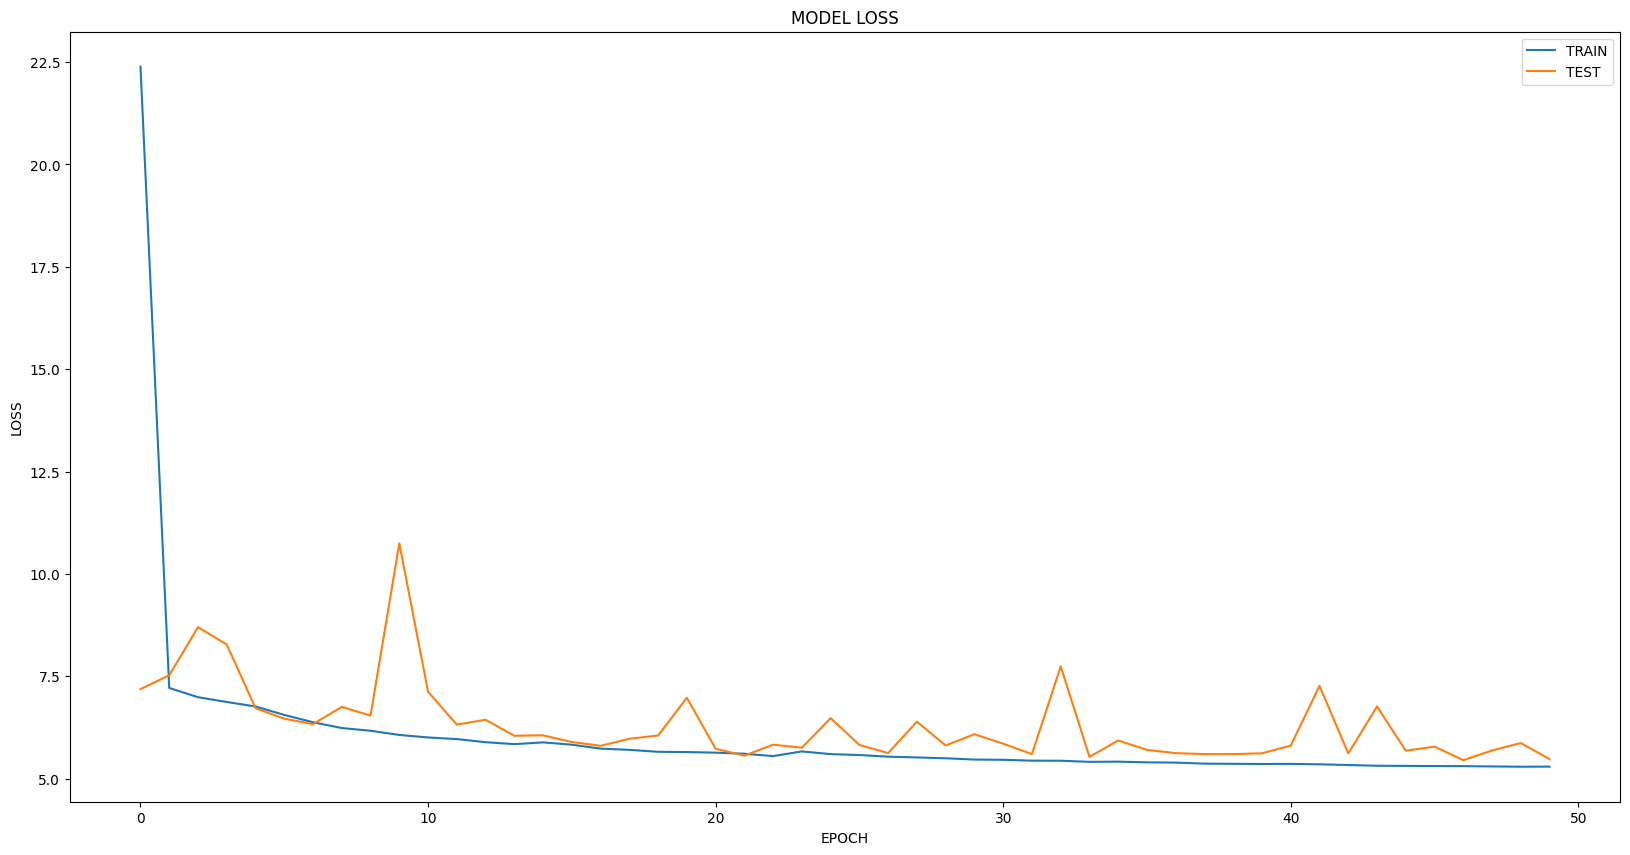

In [16]:
mp.figure(figsize = (20,10))

mp.plot(history.history['loss'])
mp.plot(history.history['val_loss'])

mp.title('MODEL LOSS')
mp.xlabel('EPOCH')
mp.ylabel('LOSS')

mp.legend(['TRAIN', 'TEST'], loc = 'upper right')
mp.show()

PREDICTING ON TESTING DATA

In [17]:
predict = model.predict(df_test, batch_size = 128, verbose = 1)

print(predict)

78/78 [==============================] - 1s 4ms/step
[[11.131832 ]
 [11.701779 ]
 [ 5.0995197]
 ...
 [30.213554 ]
 [19.619946 ]
 [ 7.515652 ]]
